In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from system_ode_fedbatch import generate_data
from machinelearning_control_fedbatch import main, generate_dataset

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


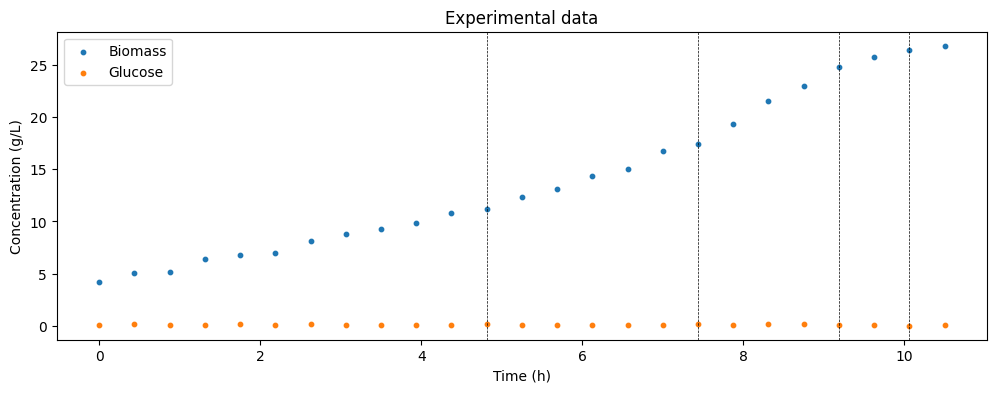

In [3]:
full_df = generate_data()

plt.figure(figsize=(12, 4))
plt.scatter(full_df['RTime'], full_df['Biomass'], s=10, label='Biomass')
plt.scatter(full_df['RTime'], full_df['Glucose'], s=10, label='Glucose')
for i in range(1, len(full_df)):
    if full_df["F"].iloc[i] != full_df["F"].iloc[i - 1]:
        plt.axvline(x=full_df["RTime"].iloc[i], color='black', linestyle='--', linewidth=0.5)
plt.xlabel('Time (h)')
plt.ylabel('Concentration (g/L)')
plt.legend()
plt.title('Experimental data')
plt.show()

In [4]:
full_df[['RTime', 'Biomass', 'Glucose']].describe().T[['min', 'max', 'mean']]

,min,max,mean
RTime,0.000000,10.500000,5.250000
Biomass,4.171923,26.823254,13.972467
Glucose,0.015173,0.226166,0.104618


In [5]:
# Get dataset (multiple initial conditions)
in_train, out_train = generate_dataset(data=full_df, num_points=1000)

Dataset shape: (1000, 4)


In [6]:
# parameter values
mumax = 0.84     # 1/hour
Ks = 0.2          # g/liter
Yxs = 0.5         # g/g
Sin = 1.43 * 200  # g/liter

t_start = 0.0
T_s = full_df['RTime'].iloc[1]
t_end = T_s

# initial conditions
V0 = full_df['V'].iloc[0]
S0 = full_df['Glucose'].iloc[0]
X0 = full_df['Biomass'].iloc[0]

print(f'T_start = {t_start}')
print(f'T_end = {t_end}')
print(f'T_s = {T_s}')

T_start = 0.0
T_end = 0.4375
T_s = 0.4375


In [7]:
import os
if os.path.exists('pinc_trained.pth'):
    net = torch.load("pinc_trained.pth")
    print('Model loaded')
else:
    # Train network
    net = main(full_df, in_train, out_train, t_start, t_end, Sin, mumax, Ks, Yxs, verbose=10)
    torch.save(net, "pinc_trained.pth")

Model loaded


# Autoregression

In [8]:
# Load the trained net
net

PINN(
  (input): Linear(in_features=4, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=2, bias=True)
)

In [9]:
from machinelearning_control_fedbatch import numpy_to_tensor
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

T_s = full_df['RTime'].iloc[1]
t_test = numpy_to_tensor(np.array([full_df["RTime"].values]))
X_test = numpy_to_tensor(np.array([full_df["Biomass"].values]))
S_test = numpy_to_tensor(np.array([full_df["Glucose"].values]))
F_test = numpy_to_tensor(np.array([full_df["F"].values]))
u_test = torch.cat([t_test, X_test, S_test, F_test], dim=1)
x_test = torch.cat([X_test, S_test], dim=1)

In [10]:
X_0 = X_test[0]
S_0 = S_test[0]
F_0 = F_test[0]

X_preds = []
S_preds = []
for i in range(len(u_test)):
    x_k = net.forward(torch.tensor([T_s, X_0, S_0, F_0], dtype=torch.float32).to(DEVICE))
    X_0 = X_test[i]
    S_0 = S_test[i]
    F_0 = F_test[i]
    X_preds.append(x_k[0].item())
    S_preds.append(x_k[1].item())



In [11]:
t_test = t_test.detach().cpu().numpy()
X_test = X_test.detach().cpu().numpy()
S_test = S_test.detach().cpu().numpy()

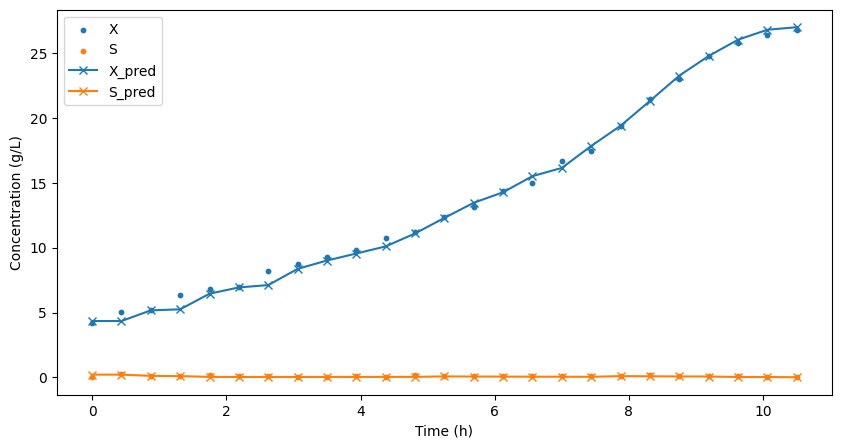

In [12]:
plt.figure(figsize=(10, 5))
plt.scatter(t_test, X_test, s=10, label="X")
plt.scatter(t_test, S_test, s=10, label="S")

plt.plot(t_test, X_preds, marker='x', label="X_pred")
plt.plot(t_test, S_preds, marker='x', label="S_pred")

plt.xlabel("Time (h)")
plt.ylabel("Concentration (g/L)")
plt.legend()
plt.show()